### Setup

This notebook explains how to to access the dataset models from django.
The datasets are loaded from the Postgres database into pandas dataframes.

To start the notebook server:

```
# Start a bash shell inside the api container
docker-compose exec api /bin/bash

# Start the jupyter notebook
python manage.py shell_plus --notebook

# Take note of the token provided and access the notebook through:
<ip-of-the-machine>:7777/?<token>
http://127.0.0.1:7777/?token=30c43675981e671b4a609cff470819098e274bbde415b7f5
```

This step has only to be made once as long as the jupyter-notebook keeps executing.
Considering that the the notebook continues to run, you can access the notebook using:
``` 
<ip-of-the-machine>:7777/?<token>
```

In [1]:
# Required to access the database
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

# Data analysis tools
import pandas as pd
import numpy as np
import seaborn as sns

# Models available in our application
from datasets.models import RawFlower, RawUNM, RawDAR
from django.contrib.auth.models import User

In [2]:
from api import adapters
from api import analysis

In [3]:


df1 = adapters.neu.get_dataframe()
df2 = adapters.unm.get_dataframe()
df3 = adapters.dar.get_dataframe()

In [4]:
analysis.cohortdescriptive(df1,df2,df3)

,level_0_cnt,Dartmouth_cnt,NEU_cnt,UNM_cnt,Dartmouth_mean,NEU_mean,UNM_mean
0,parity,10,2954,14,1.500000,1.896073,4.071429
1,birthLen,9,2954,14,47.685556,50.480759,45.928571
2,TimePeriod,10,2954,14,1.000000,1.863236,1.000000
3,preg_complications,7,2930,14,0.714286,0.093515,0.000000
4,fish,8,2954,14,1.000000,0.275220,0.196429
5,smoking,8,2912,14,0.375000,0.178915,1.571429
6,birthWt,10,2954,14,3139.474320,3177.589709,3394.000000
7,race,10,2893,14,1.000000,44.112340,3.857143
8,babySex,10,2774,14,1.500000,1.516943,1.500000
9,age,10,2954,14,31.800000,27.047393,28.285714


In [5]:
df = pd.DataFrame.from_records(
    RawUNM.objects.values()
)
df.columns

Index(['id', 'PIN_Patient', 'Member_c', 'TimePeriod', 'Analyte', 'Result',
       'Creat_Corr_Result', 'Outcome', 'Outcome_weeks', 'age', 'ethnicity',
       'race', 'education', 'BMI', 'income', 'smoking', 'parity',
       'preg_complications', 'folic_acid_supp', 'fish', 'babySex', 'birthWt',
       'birthLen'],
      dtype='object')

<AxesSubplot:xlabel='Analyte', ylabel='Analyte'>

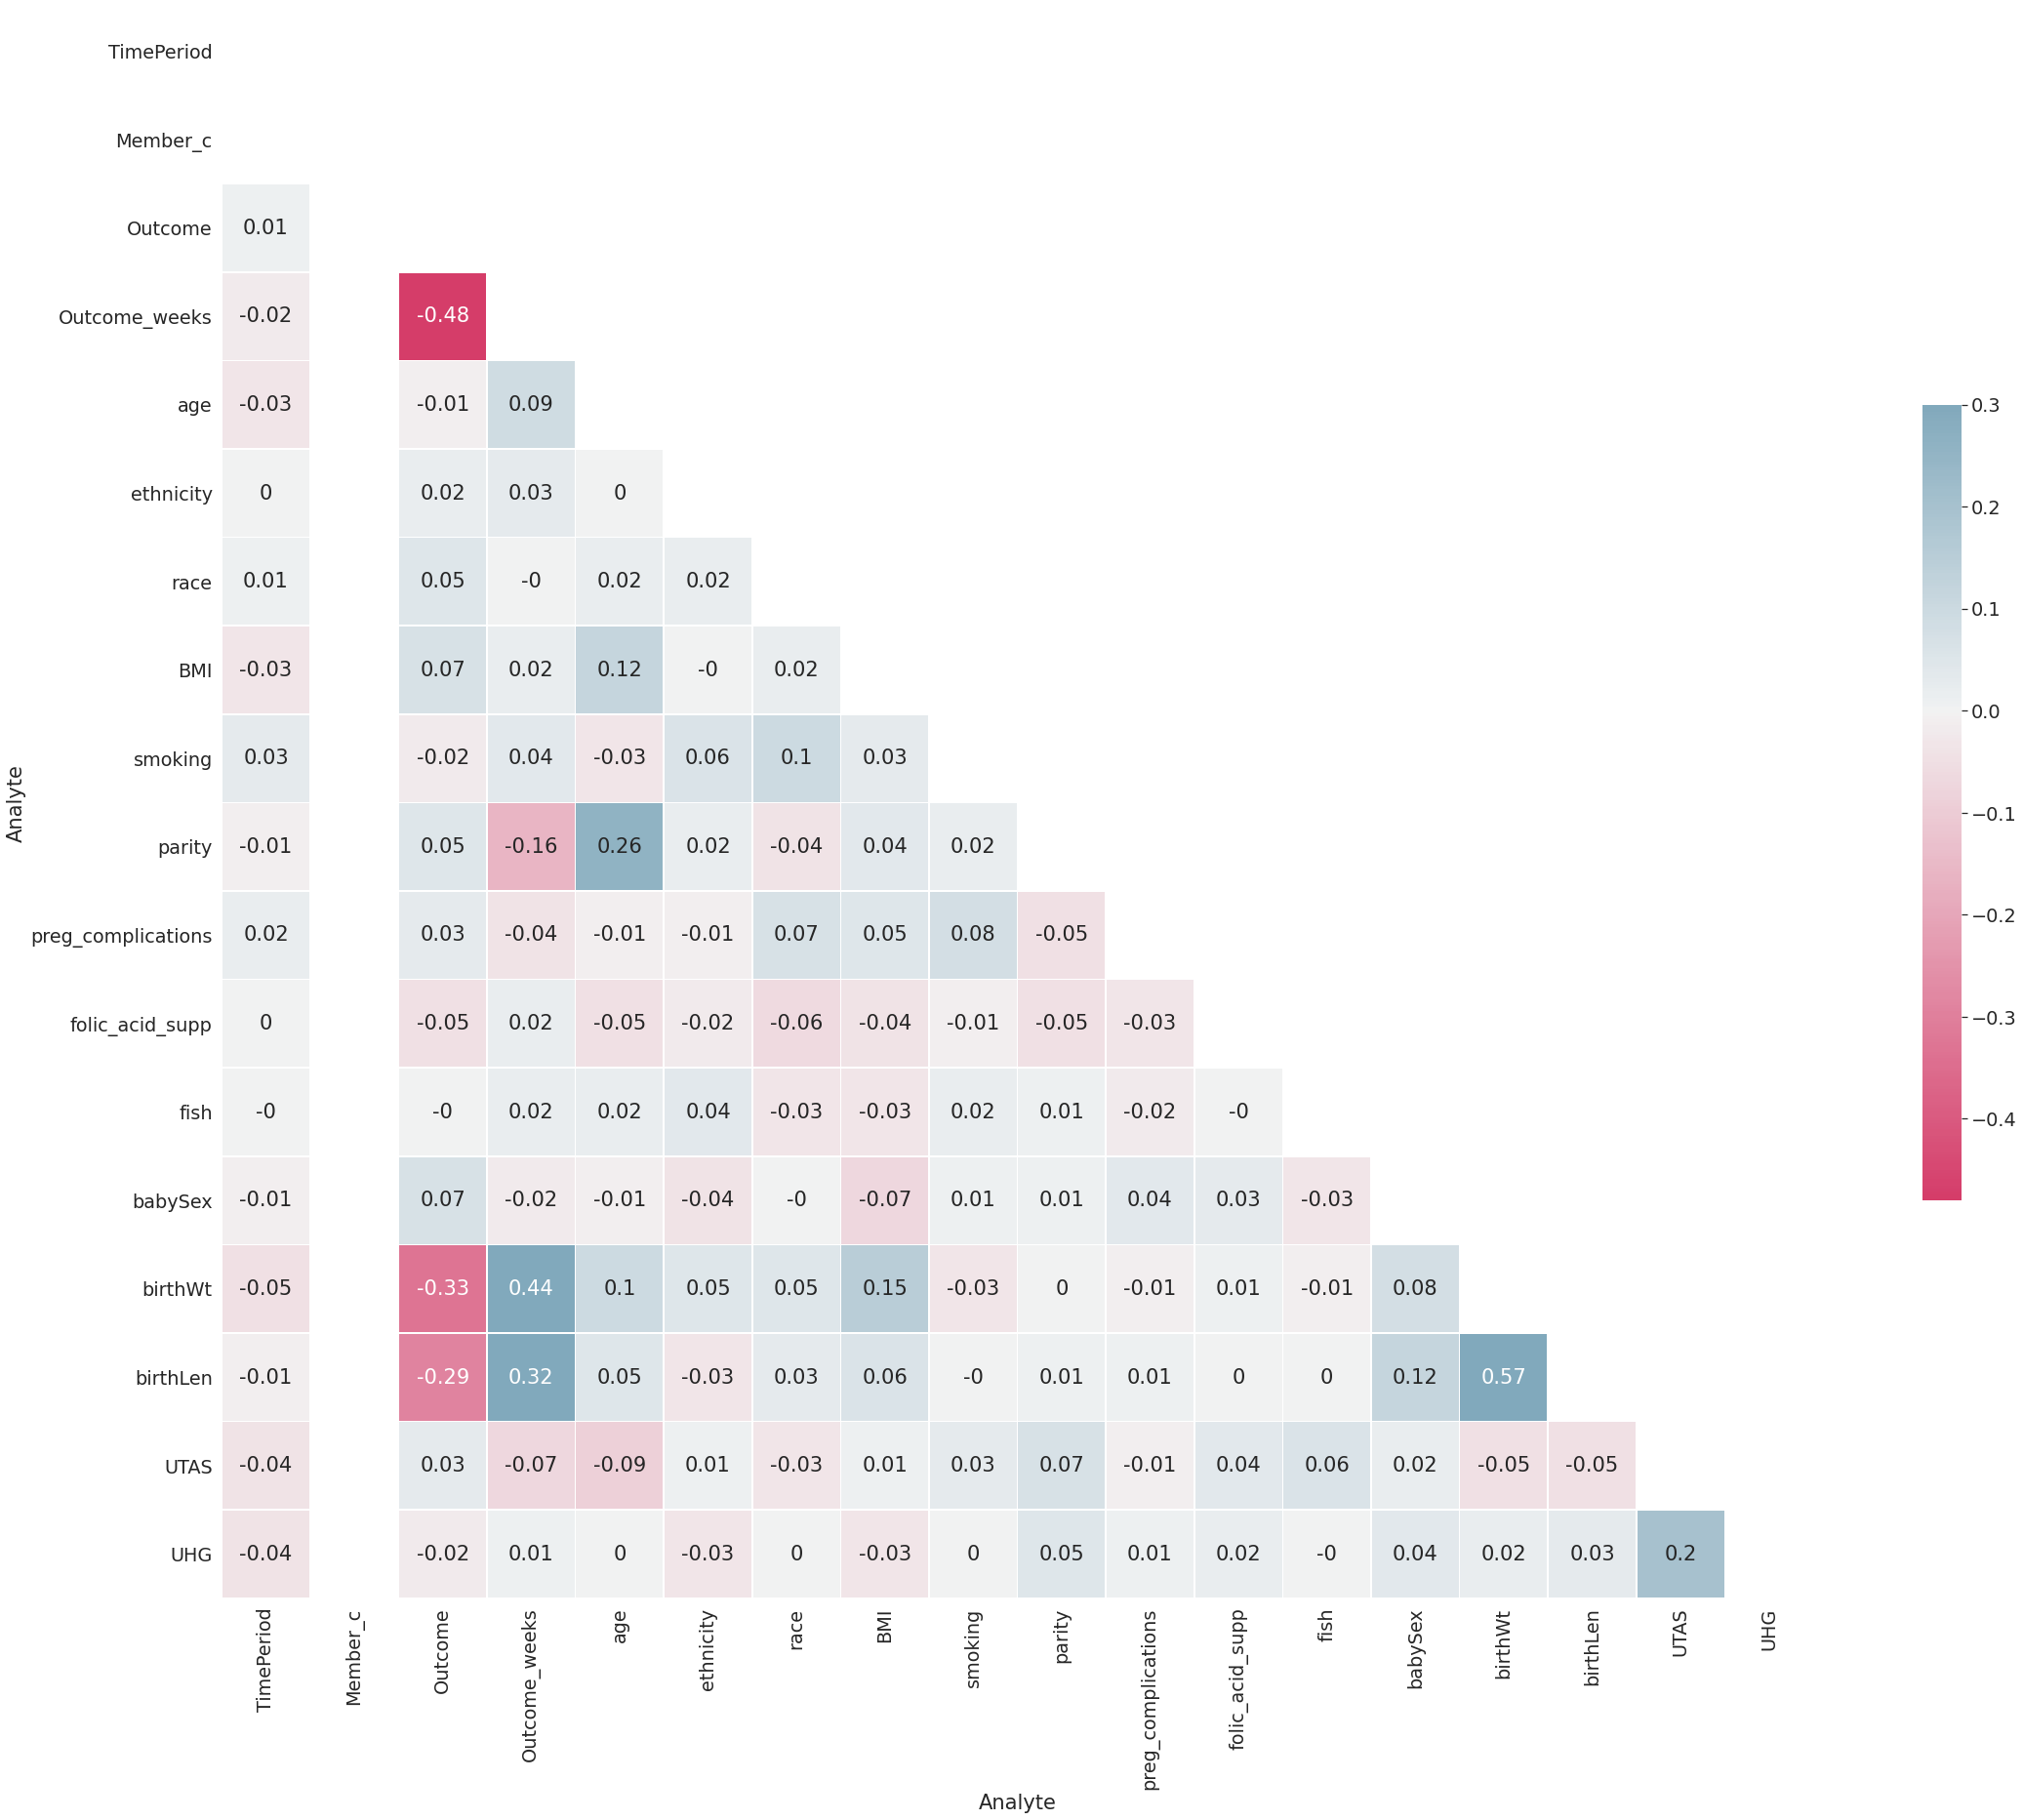

In [6]:
to_corr_cols = ['TimePeriod', 'Member_c', 'Outcome', 'Outcome_weeks', 'age',
                'ethnicity', 'race', 'BMI', 'smoking', 'parity', 'preg_complications',
                'folic_acid_supp', 'fish', 'babySex', 'birthWt', 'birthLen','UTAS','UHG']

analysis.getCorrelationHeatmap(df1, to_corr_cols)

In [7]:
x_cols = ['fish','folic_acid_supp']
y_cols = ['UHG','UTAS']

analysis.getSpearmans(df1, x_cols, y_cols).round(3)

,x,y,corr,pval
1,fish,UTAS,0.057,0.002
3,folic_acid_supp,UTAS,0.038,0.039
2,folic_acid_supp,UHG,0.019,0.315
0,fish,UHG,-0.001,0.965


In [ ]:
to_corr_cols = ['TimePeriod', 'Member_c', 'Outcome', 'Outcome_weeks', 'age',
       'ethnicity', 'race', 'education', 'BMI', 'income', 'smoking', 'parity',
       'preg_complications', 'folic_acid_supp', 'fish', 'babySex', 'birthWt',
       'birthLen', 'UTAS', 'CohortType']

analysis.getCorrelationHeatmap(df2, to_corr_cols)

<AxesSubplot:xlabel='Analyte', ylabel='Analyte'>

In [ ]:
x_cols = ['fish','folic_acid_supp']
y_cols = ['UHG']

analysis.getSpearmans(df2, x_cols, y_cols).round(3)

In [ ]:
to_corr_cols_dar = ['Member_c', 'TimePeriod', 
                   'sample_gestage_days', 'Outcome', 
                   'age','ethnicity','race','education','BMI',
                   'smoking','parity', 'preg_complications',
                   'folic_acid_supp','babySex',
                   'birthWt','birthLen','headCirc','ponderal','PNFFQTUNA',
                   'PNFFQFR_FISH_KIDS','PNFFQSHRIMP_CKD','PNFFQDK_FISH','PNFFQOTH_FISH',
                   'mfsp_6','fish','TOTALFISH_SERV','UIAS', 'UASB', 'UAS3', 'UAS5','UHG','UAS']

analysis.getCorrelationHeatmap(df3, to_corr_cols_dar)

In [ ]:
x_cols = ['PNFFQFR_FISH_KIDS','PNFFQSHRIMP_CKD','PNFFQDK_FISH','PNFFQOTH_FISH','mfsp_6','fish','TOTALFISH_SERV']
y_cols = ['UIAS', 'UASB', 'UAS3', 'UAS5','UHG','UAS']

analysis.getSpearmans(df3, x_cols, y_cols).round(3)[0:20]